In [4]:
# Colab에 Mecab 설치
!pip install konlpy
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.0 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   995k      0  0:00:01  0:00:01 --:--:-- 4590k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/confi

### 리뷰 감성 분류 모델 개발
#### https://wikidocs.net/94600
#### https://inhovation97.tistory.com/61

#### 사이트 참조

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()
[f for f  in sys_font if 'Nanum' in f]
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname = path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

FileNotFoundError: ignored

In [5]:
import re
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow
from collections import Counter
from konlpy.tag import Okt
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
t_df = pd.read_csv('/content/drive/MyDrive/빅데이터5/BigData/티처빌_데이터셋.csv', encoding='cp949')
t_df

,credit,name,reviews,ratings,category,date,label,tokenized
0,1학점,"1인 미디어 전성시대, 유튜브 브런치",유튜브 시청은 쉬워도 유튜브 제작은 마냥 어려운 일이었는데 그 간격을 조금은 줄여주...,4,디지털활용,2023-10-22,1,"['유튜브', '시청', '쉬워도', '유튜브', '제작', '마냥', '어려운',..."
1,1학점,15가지 스킬로 끝내는 영어 리스닝 무작정 따라하기,귀에 쏙쏙 들어오게 설명해주셔서 정말 좋았어요 감사합니다,5,어학,2023-10-22,1,"['귀', '쏙쏙', '들어오', '설명', '해', '주', '셔서', '정말',..."
2,0학점,2023년 학원 및 교습소 설립·운영자 연수,교습소 운영에 도움 되는 정보들을 얻을 수 있어 유익한 시간이 되었던 것 같습니다,5,학습지도,2023-10-22,1,"['교습소', '운영', '도움', '되', '정보', '얻', '수', '있', ..."
3,4학점,위로와 격려로 다시 쓰는 교사 위기 극복 가이드,좋은 연수예요 듣기 부담스럽지 않으면서 어디서도 듣기 어려운 적당히 가볍고 적당히 ...,5,생활지도,2023-10-22,1,"['좋', '연수', '예요', '듣', '기', '부담', '스럽', '않', '..."
4,1학점,"아는 만큼 쌓이는 금융잔고, 교사 금융문맹 탈출기(주식, 부동산)",연수 제목과 맞게 금융문명탈출을 위한 기초적인 내용을 알게 되었어요 차근차근 설명...,4,인문·교양,2023-10-22,1,"['연수', '제목', '맞', '금융', '문명', '탈출', '위한', '기초'..."
...,...,...,...,...,...,...,...,...
14623,1학점,현장 멘토들과 함께 하는 인도주의 실천 가이드,학교 교육에서 인성교육이 중요하다 인도주의도 인성교육 측면에서 필요한데 연수를 통해...,5,인문·교양,2023-07-22,1,"['학교', '교육', '인성', '교육', '중요', '인도주의', '인성', '..."
14624,1학점,누구나 쉽게 할 수 있는 AI 코딩블록 (AI 코디니),코딩에 대한 기초적인 지식을 알 수 있었으며 티쳐블 머신이나 딥러닝 같은 개념들도 ...,5,디지털활용,2023-07-22,1,"['코딩', '대한', '기초', '적', '지식', '알', '수', '있', '..."
14625,1학점,"미래교육의 첫 걸음, 학교자치",모바일 연수로 좋았어요 자치에 대한 이론적 개념이 좋았구요 실제적 예시가 더 있으면 해요,5,생활지도,2023-07-22,1,"['모바일', '연수', '좋', '았', '어요', '자치', '대한', '이론'..."
14626,2학점,스마트한 교실을 위한 영재교육비법,이번 연수를 통해 재능이 뛰어난 학생을 조기에 발굴하여 타고난 잠재력을 계발할 수 ...,5,학습지도,2023-07-22,1,"['연수', '통해', '재능', '뛰어난', '학생', '조기', '발굴', '타..."


In [7]:
#drop 전처리

t_df.drop(['credit'], axis =1, inplace=True)
t_df.drop(['name'], axis =1, inplace=True)
t_df.drop(['date'], axis =1, inplace=True)
t_df.drop(['category'], axis =1, inplace=True)
t_df.drop(['tokenized'], axis =1, inplace=True)
t_df.drop(['ratings'], axis =1, inplace=True)
t_df

,reviews,label
0,유튜브 시청은 쉬워도 유튜브 제작은 마냥 어려운 일이었는데 그 간격을 조금은 줄여주...,1
1,귀에 쏙쏙 들어오게 설명해주셔서 정말 좋았어요 감사합니다,1
2,교습소 운영에 도움 되는 정보들을 얻을 수 있어 유익한 시간이 되었던 것 같습니다,1
3,좋은 연수예요 듣기 부담스럽지 않으면서 어디서도 듣기 어려운 적당히 가볍고 적당히 ...,1
4,연수 제목과 맞게 금융문명탈출을 위한 기초적인 내용을 알게 되었어요 차근차근 설명...,1
...,...,...
14623,학교 교육에서 인성교육이 중요하다 인도주의도 인성교육 측면에서 필요한데 연수를 통해...,1
14624,코딩에 대한 기초적인 지식을 알 수 있었으며 티쳐블 머신이나 딥러닝 같은 개념들도 ...,1
14625,모바일 연수로 좋았어요 자치에 대한 이론적 개념이 좋았구요 실제적 예시가 더 있으면 해요,1
14626,이번 연수를 통해 재능이 뛰어난 학생을 조기에 발굴하여 타고난 잠재력을 계발할 수 ...,1


In [8]:
t_df['reviews'].nunique(), t_df['label'].nunique()

(14626, 2)

In [9]:
t_df.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(t_df))

총 샘플의 수 : 14626


In [10]:
print(t_df.isnull().values.any())  # null 값 유무 확인

False


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

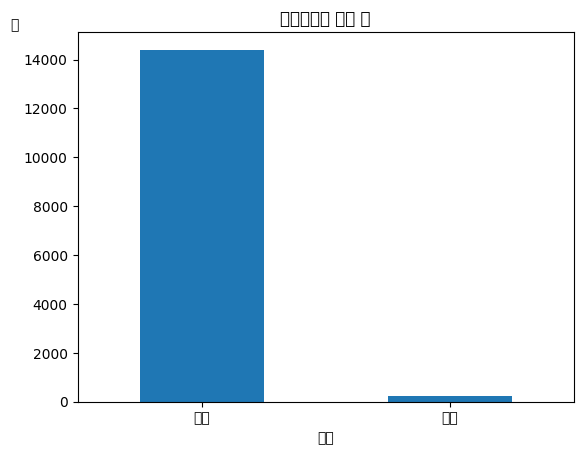

<Figure size 640x480 with 0 Axes>

In [17]:
t_df['label'].value_counts().plot(kind='bar')
plt.title('아이스크림 후기 수')
plt.ylabel('개', loc = 'top', rotation = 0)
plt.xlabel('분류')
plt.xticks([0, 1], ['긍정', '부정'], rotation = 0)
plt.show()
plt.savefig('/content/drive/MyDrive/빅데이터5/BigData/티처빌_부긍정분포도.png')

In [ ]:
df = t_df
df

,reviews,label
0,유튜브 시청은 쉬워도 유튜브 제작은 마냥 어려운 일이었는데 그 간격을 조금은 줄여주...,1
1,귀에 쏙쏙 들어오게 설명해주셔서 정말 좋았어요 감사합니다,1
2,교습소 운영에 도움 되는 정보들을 얻을 수 있어 유익한 시간이 되었던 것 같습니다,1
3,좋은 연수예요 듣기 부담스럽지 않으면서 어디서도 듣기 어려운 적당히 가볍고 적당히 ...,1
4,연수 제목과 맞게 금융문명탈출을 위한 기초적인 내용을 알게 되었어요 차근차근 설명...,1
...,...,...
14623,학교 교육에서 인성교육이 중요하다 인도주의도 인성교육 측면에서 필요한데 연수를 통해...,1
14624,코딩에 대한 기초적인 지식을 알 수 있었으며 티쳐블 머신이나 딥러닝 같은 개념들도 ...,1
14625,모바일 연수로 좋았어요 자치에 대한 이론적 개념이 좋았구요 실제적 예시가 더 있으면 해요,1
14626,이번 연수를 통해 재능이 뛰어난 학생을 조기에 발굴하여 타고난 잠재력을 계발할 수 ...,1


### 훈련 데이터와 테스트 데이터 분리하기

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 123)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 10969
테스트용 리뷰의 개수 : 3657


In [ ]:
train_data[:1]

,reviews,label
5119,필수 연수가 모두 묶여있어서 더이상 고민할 필요가 없어요 한방에 끝내요필수 연수가 ...,1


In [ ]:
train_data['reviews'].nunique(), train_data['label'].nunique()

(10969, 2)

In [ ]:
train_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 10969


<Axes: >

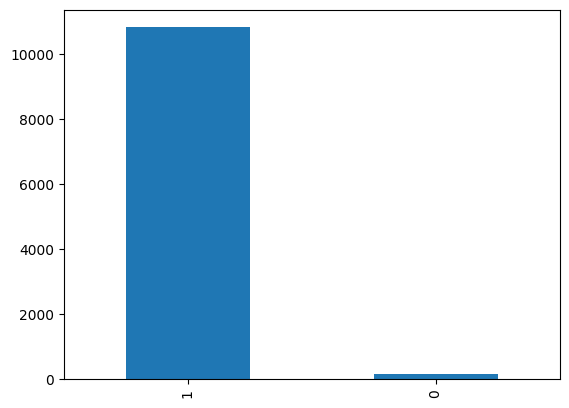

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0    156
1      1  10813


In [ ]:
print(train_data.isnull().sum())

reviews    0
label      0
dtype: int64


In [ ]:
## 데이터 전처리

In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(axis=0)
train_data[:5]

<ipython-input-105-0f0f83597a02>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-105-0f0f83597a02>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,reviews,label
5119,필수 연수가 모두 묶여있어서 더이상 고민할 필요가 없어요 한방에 끝내요필수 연수가 ...,1
13025,고생 많으셨습니다 방법을 몰라 못 하는 수업이 많았었는데노하우를 보고 나니 나도 할...,1
7983,구체적인 사례를 통해 알기 쉽게 연수해주셨습니다 감사합니다,1
6530,편하고 재미있게 너무 잘 들었습니다 년마다 들어야 하는데 도움이 많이 됐어요,1
9700,아이들과 함께 해보면서 공부할 수 있었던 행복한 연수였습니다홍어가 비싸라는 아버님의...,1


In [ ]:
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(axis=0)
test_data.drop_duplicates(subset=['reviews'], inplace=True)

<ipython-input-106-5dc06290cb65>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-106-5dc06290cb65>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [ ]:
print(len(test_data))

3657


## 토큰화


In [ ]:
okt = Okt()

In [ ]:
stopwords = open("/content/drive/MyDrive/빅데이터5/BigData/불용어_add.txt", "r")
stopwords = stopwords.read().splitlines()

In [ ]:
drop_list = ['연수', '있', '었', '되', '내용', '강의', '기', '좋', '너무', '수', '합니다', '했', '같', '주', '교육', '았', '면', '해', '많', '어요', '듣', '보', '는데', '알', '과정', '수업', '교직', '잡', '듣', '으면', '적', '치유', '라는', '성', '학부모', '나오', '할', ' 법','했', '님', '잘', '어요', '학생', '어서', '듣', '더', '겠', '싶', '교육', '입니다', '면', '교사', '선생', '시', '며', '만', '대한', '네요', '라', '면서', '해서', '번', '셔서', '방법', '공부', '학교', '된', '읽', '될', '학년', '라는', '아서', '책', '신', '과정', '교실', '속', '현장', '여행', '수강', '현장', '사회', '두', '였', '사례']

In [ ]:
negative_words = train_data[train_data.label == 0]['reviews']
positive_words = train_data[train_data.label == 1]['reviews']
negative_words

9012     학부모가 들어야 할 연수인 것 같은데 왜 자꾸 교사에게만 듣기를 강요합니까 왜 매년...
10358    생성형 에 대해서 보다 자세히 배울 수 있었습니다 다만 교육 현장에서 활용할 수 있...
12395    다문화 교육에 대한 구체적인 교수학습 및 다문화 학생에 대한 이해도를 높이고 싶었는...
11113    재미있는데 조금 어려워요 기능이 많아 반복해서 들어야 손에 익습니다 아이패드를 자주...
10164           수업에 도움되는 내용을 얻을 수 있을것이라 생각했는데 생각만큼은 아니었습니다
                               ...                        
12448    내용이 방대하지만 깊이는 없어서 아쉽네요 년차 주부에게는 다 아는 내용이라 도움이 ...
11371                  실용영어 학습에 대한 생각을 다시 여러모로 짚어볼 수 있었습니다
5747     학생들의 안전한 테두리가 되어주는 교사가 되고 싶으며 생명 지킴이로서의 역할에 대해...
13040    연수를 들으면서 불편한 점이 너무 많았습니다 강사님과 인터뷰받는 사람도 정말 훌륭하...
6257     필수 연수라서 시작했는데 학교 생활에 도움이 되는 내용이 많이 있었습니다 다만 해마...
Name: reviews, Length: 156, dtype: object

In [ ]:
neg_t = []
for i in negative_words:
  neg = okt.morphs(i, stem=True) #토큰화
  neg_t.append(neg)


In [ ]:
pos_t = []
for i in positive_words:
  pos = okt.morphs(i, stem=True) #토큰화
  pos_t.append(pos)


In [ ]:
negative_word_count = Counter(np.hstack(neg_t))
positive_word_count = Counter(np.hstack(pos_t))
print(len(negative_word_count))
print(negative_word_count.most_common(20))
print(positive_word_count.most_common(20))

1303
[('하다', 294), ('이', 202), ('을', 160), ('연수', 114), ('있다', 114), ('에', 112), ('가', 98), ('를', 88), ('의', 78), ('내용', 75), ('들', 71), ('것', 66), ('수', 63), ('되어다', 62), ('도', 58), ('되다', 50), ('들다', 48), ('강의', 48), ('좋다', 45), ('같다', 41)]
[('하다', 15706), ('을', 10622), ('이', 9213), ('있다', 8785), ('에', 7644), ('연수', 6794), ('를', 6461), ('수', 5741), ('의', 5295), ('들', 4941), ('이다', 4669), ('좋다', 4402), ('되어다', 3949), ('가', 3698), ('되다', 3623), ('유익하다', 3227), ('것', 3030), ('도움', 2609), ('으로', 2583), ('적', 2476)]


In [ ]:
f = open('공통단어리스트.txt', 'w')
common = negative_word_count & positive_word_count
common_list = list(common)
print(common_list)
f.close

['학부모', '가', '들다', '하다', '연수', '인', '것', '같다', '왜', '자꾸', '교사', '에게만', '듣기', '를', '합', '니까', '매년', '똑같다', '생', '성형', '에', '대해', '서', '보다', '자세하다', '배우다', '수', '있다', '다만', '교육', '현장', '에서', '활용', '플랫폼', '좀', '더', '줄', '알다', '인공', '지능', '의', '현주소', '와', '네이버', '위치', '등', '주로', '다루다', '점', '이', '조금', '아쉽다', '다문화', '대한', '구체', '적', '교수', '학습', '및', '학생', '이해도', '높이', '고', '싶다', '크다', '도움', '되다', '못', '특히', '시험', '문제', '는', '각', '나라', '특징', '알', '지', '평가', '없다', '수고', '강사', '님', '감사하다', '재미있다', '어렵다', '기능', '많다', '반복', '손', '익다', '아이패드', '자주', '사용', '투자', '가치', '라고', '생각', '수업', '내용', '을', '얻다', '만큼은', '아니다', '학교', '자치', '개념', '정립', '받다', '사례', '활동', '참고', '위해', '신청', '한', '여서', '아쉬움', '이번', '프로그램', '통', '하', '여', '제', '모르다', '부분', '도', '게', '되어다', '자살', '방지', '주위', '사람', '들', '내', '가족', '고충', '이나', '힘드다', '애기', '때', '심다', '같이', '고민', '하고', '들어주다', '과', '크나크다', '공부', '관심', '가다', '사회', '나', '다른', '입장', '충', '동', '대하', '다시', '한번', '유심', '히', '관찰', '동작', '떨어지다', '설명', '부족하다', '혼자', '표현', '관계',

<function TextIOWrapper.close()>

In [ ]:
X_train = []
for sentence in train_data['reviews']:
  temp_X = okt.morphs(sentence, stem=True) #토큰화
  temp_X = [word for word in temp_X if not word in stopwords and not word in drop_list and not word in common_list]
  X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['묶이다', '방', '끝내', '묶이다', '방', '끝내', '묶이다', '방', '끝내', '묶이다', '방', '끝내', '묶이다', '방', '끝내'], ['노하우', '나니'], []]


In [ ]:
X_test = []
for sentence in test_data['reviews']:
  temp_X = okt.morphs(sentence, stem=True) #토큰화
  temp_X = [word for word in temp_X if not word in stopwords and not word in drop_list and not word in common_list]
  X_test.append(temp_X)

In [ ]:
X_train, X_test

([['묶이다',
   '방',
   '끝내',
   '묶이다',
   '방',
   '끝내',
   '묶이다',
   '방',
   '끝내',
   '묶이다',
   '방',
   '끝내',
   '묶이다',
   '방',
   '끝내'],
  ['노하우', '나니'],
  [],
  [],
  ['행복하다', '홍어', '아버님', '덕분', '응원'],
  ['과학', '타'],
  ['나르다', '살피다'],
  ['예쁘다', '쓸다', '연습'],
  ['습관', '이루다'],
  ['종류', '마술', '스킬', '흥미', '롭고', '보내다', '넘다'],
  ['단축키'],
  ['게이트', '키퍼', '갖추다', '소양'],
  ['학', '습량', '핵심', '동사', '일상생활', '배배'],
  ['기초', '학력', '추가'],
  ['음악'],
  ['그린', '스마트', '구축', '아이디어'],
  ['부탁드리다'],
  ['귀', '쏙쏙', '들어오다'],
  ['울리다', '눈물', '줄줄', '흘리다', '힘내다'],
  ['일주일', '뭐', '찾다', '도중'],
  [],
  ['강요', '야합'],
  ['울'],
  ['깨', '달다'],
  ['재정',
   '집짓기',
   '재정',
   '관해',
   '인생',
   '설계',
   '절제',
   '자산',
   '부채',
   '통한',
   '지수',
   '부채',
   '비율',
   '비상',
   '예비',
   '자금',
   '과소',
   '비지'],
  ['고등학생',
   '시절',
   '교과목',
   '한국사',
   '성인',
   '한국',
   '분량',
   '압도',
   '겁',
   '최태성',
   '맛깔나다',
   '나무',
   '숲',
   '시대',
   '세부',
   '덕분',
   '한국인',
   '우리나라',
   '뿌듯하다',
   '한국사',
   '검정'],
  ['어렴풋이', '나마', '대학입

### 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'기초': 1, '정리': 2, '한국사': 3, '감사': 4, '학급': 5, '공감': 6, '더욱': 7, '시대': 8, '미래': 9, '경제': 10, '요즘': 11, '재밌다': 12, '연습': 13, '최태성': 14, '거': 15, '찾다': 16, '짧다': 17, '대처': 18, '흥미': 19, '주변': 20, '중심': 21, '에게도': 22, '감정': 23, '흥미롭다': 24, '실생활': 25, '음악': 26, '깊다': 27, '학기': 28, '쓰다': 29, '자신감': 30, '쏙쏙': 31, '적절하다': 32, '만족하다': 33, '학점': 34, '항상': 35, '행복하다': 36, '힐링': 37, '문화': 38, '덕분': 39, '최고': 40, '효과': 41, '입시': 42, '건강': 43, '몸': 44, '실질': 45, '체계': 46, '학력': 47, '회화': 48, '들어오다': 49, '인성': 50, '두다': 51, '대입': 52, '고교': 53, '바탕': 54, '핵심': 55, '기르다': 56, '그동안': 57, '향상': 58, '이제': 59, '작가': 60, '귀': 61, '소통': 62, '돌아보다': 63, '역시': 64, '일상생활': 65, '만나다': 66, '타일러': 67, '관리': 68, '겠다': 69, '화가': 70, '안내': 71, '청소년': 72, '바라보다': 73, '상식': 74, '감상': 75, '친절하다': 76, '힘': 77, '시기': 78, '담임': 79, '일본어': 80, '세계': 81, '살펴보다': 82, '나르다': 83, '부탁드리다': 84, '주시': 85, '에서의': 86, '나가다': 87, '관점': 88, '보내다': 89, '연주': 90, '력': 91, '추하다': 92, '알아보다': 93, '도전': 94, '어리다': 95, '가볍다': 96, '배경': 97,

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합의 크기 : 7646
등장 빈도가 2번 이하인 희귀 단어의 수: 4673
단어 집합에서 희귀 단어의 비율: 61.11692388176825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.616879089217472


In [ ]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2974


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[1362, 765, 1735, 1362, 765, 1735, 1362, 765, 1735, 1362, 765, 1735, 1362, 765, 1735], [213, 274], []]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

9397
9397


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩

리뷰의 최대 길이 : 159
리뷰의 평균 길이 : 4.700755560285198


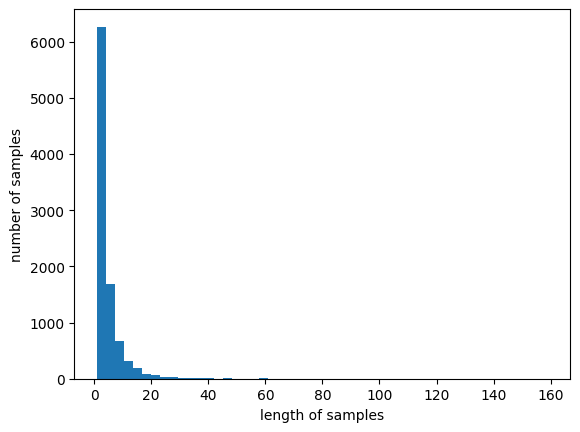

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 150
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 99.98935830584229


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
X_train ,y_train

### 분포도 차이의 의한 oversampling

In [ ]:
print(X_train.shape , X_test.shape)

(9397, 150) (3657, 150)


In [ ]:
#모델링
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)

In [ ]:
#평가 지표
def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)



print('\n SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_train).value_counts())
print('\n SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ValueError: ignored

## GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
working_dir = '/content/drive/MyDrive/빅데이터5/BigData'
best_model_filename = os.path.join(working_dir, f'best_model.h5')
print(best_model_filename)
model.save_weights('/content/drive/MyDrive/빅데이터5/BigData/best_model.h5')

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  f = open("/content/drive/MyDrive/빅데이터5/BigData/불용어.txt", "r")
  stop_words = f.read().splitlines()
  new_sentence = [word for word in new_sentence if not word in stop_words]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
mecab = Mecab()

In [ ]:
sentiment_predict('이 강의 진짜 좋아요... 저는 강추합니다. 대박')

In [ ]:
sentiment_predict('선생님... 너무 짱이에요.. 대박나삼')

In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

In [ ]:
sentiment_predict('평소에 접하지 못한 부분을 공부하여 좋았습니다다만  스마트폰 기능을 찿는데 시간이 걸려서 따라하는 시간이 다소 소요되었습니다스마튼 폰마다 기능이 각각다르므로  자세히 찿는 방법을 알려주었으면 하는 아쉬움이 남았습니다감사합니다')